## Cloning quasars

Let's look at the redshift distributions of the quasars in the Sloan Digital Sky Survey.

The Sloan Digital Sky Survey or SDSS is a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States. Operations started in 1998.

In phase 1, SDSS has released photometry data 357 million (!!!) unique sources and 1.6 million spectra. In phase 2, SDSS observed the same patch of the sky many times ("time domain astronomy", and now we're going to have LSST!)

![](https://classic.sdss.org/includes/sideimages/sdss_pie2.jpg)

In [1]:
import numpy as np
import scipy.stats
import pylab as plt

from astropy.stats import median_absolute_deviation
from astroML import stats as astroMLstats

from tqdm import tqdm

Download the SDSS quasara data

In [2]:
from astroML.datasets import fetch_dr7_quasar

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

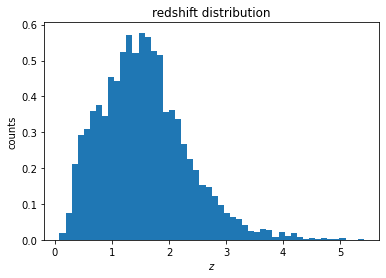

In [10]:
plt.hist(z,bins=50,density=True)
plt.xlabel(r'$z$')
plt.ylabel('counts')
plt.title('redshift distribution')
plt.show()

- Upsample this distribution in two ways, using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)

(Hint: `scipy.stats` is your best friend)

In [94]:
z.shape

(10000,)

Text(0.5, 1.0, 'Interpolated $z$-distribution')

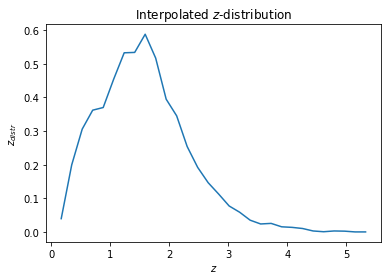

In [176]:
# create an histogram object to sample the distribution
z_distr,z_bins = np.histogram(z,bins=30,density=True)

# the above passage can be done also with: disth = scipy.stats.rv_histogram((counts,bins))
# this function has also already a re-sample method: disth.rvs(size=N)

mid_zbins = (z_bins[1:] + z_bins[:-1]) / 2 # mid location of bins

# interpolate to get an empirical function
empirical_distr = scipy.interpolate.interp1d(mid_zbins,z_distr)

#plot
plt.plot(mid_zbins,empirical_distr(mid_zbins))
plt.xlabel(r'$z$')
plt.ylabel(r'$z_{distr}$')
plt.title(r'Interpolated $z$-distribution')

### Rejection sampling

In [95]:
N_points = 1000000

# define the z range
z_min = min(mid_zbins)
z_max = max(mid_zbins)

# define the y range
y_min = min(z_distr)
y_max = max(z_distr)

# sample new values of z:
z_sampled = []
y_sampled = []

while(len(z_sampled)<N_points):
    z_extract = np.random.uniform(z_min,z_max)
    y = np.random.uniform(y_min,y_max)
    if(y<empirical_distr(z_extract)):
        z_sampled.append(z_extract)
        y_sampled.append(y)

Text(0.5, 0, '$z$')

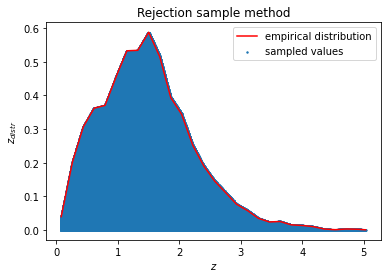

In [96]:
plt.plot(np.sort(z_sampled),empirical_distr(z_sampled)[np.argsort(z_sampled)],color='red',label='empirical distribution')
plt.scatter(z_sampled,y_sampled,label='sampled values',s=2)
plt.legend()
plt.title('Rejection sample method')
plt.ylabel(r'$z_{distr}$')
plt.xlabel(r'$z$')

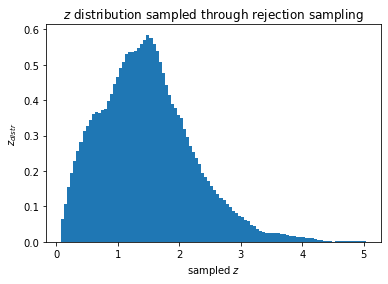

In [110]:
plt.hist(z_sampled,bins=100,density=True)
plt.title(r'$z$ distribution sampled through rejection sampling')
plt.xlabel(r'sampled $z$')
plt.ylabel(r'$z_{distr}$')
plt.show()

In [108]:
# write a file to avoid running every time the cell above
with open('z_upsample_rejection.txt','w') as file:
    file.write('z\n\n')
    for i in range(N_points):
        file.write(str(z_sampled[i])+'\n')
        
file.close()

### Inverse transform sampling

Text(0.5, 1.0, 'Numerical cdf')

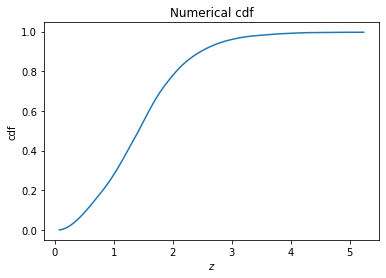

In [137]:
# computing the cdf, integrating numerically
z_grid = np.linspace(z_min,z_max,10000)
empirical_cdf = np.zeros(len(z_grid))

for i in range(len(z_grid)):
    empirical_cdf[i] = np.trapz(empirical_distr(z_grid[:i]),z_grid[:i])

# we could also use np.cumsum that gives the cumulative sum
    
plt.plot(z_grid,empirical_cdf)
plt.xlabel(r'$z$')
plt.ylabel(r'cdf')
plt.title('Numerical cdf')

In [160]:
# interpolate the cdf:
cdf_interp = scipy.interpolate.interp1d(z_grid,empirical_cdf)

# now we need to generate random samples between 0 and 1 and use cdf^{-1} to extract the values
eps = np.random.uniform(0,1,N_points)

# invert the cdf and extract the samples
invers_cdf = []
z_samples_inv_tr = []

for e in tqdm(eps):
    idx = np.where(abs(empirical_cdf-e)==min(abs(empirical_cdf-e)))[0][0]
    invers_cdf.append(empirical_cdf[idx])
    z_samples_inv_tr.append(z_grid[idx])


100%|██████████| 1000000/1000000 [11:22<00:00, 1465.02it/s]


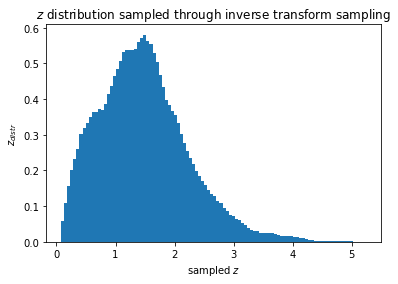

In [173]:
# mask to avoid outliers
z_samples_inv_tr_np = np.array(z_samples_inv_tr)
mask = z_samples_inv_tr<z_max

plt.hist(z_samples_inv_tr_np[mask],bins=100,density=True)
plt.title(r'$z$ distribution sampled through inverse transform sampling')
plt.xlabel(r'sampled $z$')
plt.ylabel(r'$z_{distr}$')
plt.show()

In [182]:
# another possibility is to interpolate directly the inverse cumulative_func:
inv_cum_interp = scipy.interpolate.interp1d(empirical_cdf,z_grid)

# generate the uniform distribution for the sampling:
eps_sampl = np.random.uniform(min(empirical_cdf),max(empirical_cdf),N_points)

# extrapolate directly the sampled z:
z_sampled_inv_tr = inv_cum_interp(eps_sampl)

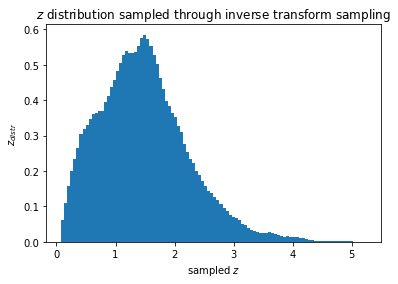

In [183]:
plt.hist(z_sampled_inv_tr,bins=100,density=True)
plt.title(r'$z$ distribution sampled through inverse transform sampling')
plt.xlabel(r'sampled $z$')
plt.ylabel(r'$z_{distr}$')
plt.show()

In [184]:
# write a file to avoid running every time the cell above
with open('z_upsample_inverse_transform.txt','w') as file:
    file.write('z\n\n')
    for i in range(N_points):
        file.write(str(z_sampled_inv_tr[i])+'\n')
        
file.close()

- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data. Does that agree with your expectation? 

(Hint: It shouldn't. But why?) 

(Hint: `astropy.cosmology` is another close friend). The best-fit cosmological model from the Plack data is:

In [175]:
import astropy
astropy.cosmology.Planck18

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)